In [2]:
# pip install xmltodict

In [172]:
# 농수축 & 이미용 EDAddd
# !pip install plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tqdm.notebook import tqdm
import requests
import xmltodict
import re
# pd.set_option('display.max_rows', 100)
%matplotlib inline
plt.style.use('ggplot') # 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.rcParams['font.family'] = 'Malgun Gothic'

In [173]:
# 나눔고딕코드 폰트 설치 (필요한사람만 돌리세요)
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# plt.rc('font', family='NanumBarunGothic')

In [174]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    from google.colab import drive
    drive.mount('/content/drive')
    sum_df = pd.read_csv('/content/drive/My Drive/빅데이터_콘테스트/sum_df.csv')

else:
    print('Not running on CoLab')
    sum_df = pd.read_csv('c:/bc/sum_df.csv')

Not running on CoLab


In [175]:
seasons = [4, 4, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4]
month_to_season = dict(zip(range(1,13), seasons))

sum_df['season'] = sum_df.MONTH.map(month_to_season)

In [176]:
sum_df['timeslot'] = pd.cut(sum_df.HOUR, bins = [0,8,11,14,17,20,23,26], \
                             labels = [1,2,3,4,5,6,7])

In [177]:
month = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

total = {}
for i in month:
    service_key = 'JJC5IlOjBjhMwMvARvd2a0D3jVjHuA3DDvF1NZ27DH4pbq5Y1bzUmA0zYt6BOvI562qNa8Z87PlDLZZjYHA3YA%3D%3D'
    service_key_decode = requests.utils.unquote(service_key)

    req_params = {'ServiceKey' : service_key_decode, 'solYear' : '2019', 'solMonth' : i}
    req_url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getHoliDeInfo'

    resp = requests.get(req_url, params =req_params)
    xml_data = resp.text
    dict_data = xmltodict.parse(xml_data)

    if dict_data ['response']['body']['items'] is not None:
        data = dict_data ['response']['body']['items']['item']

        total[i] =  data

month_1 = ['01', '03', '06', '08', '12']

공휴일 = []
for  mon in month:
    if mon in month_1 :
        date = total[mon]['locdate']
        holiday = total[mon]['isHoliday']
        공휴일.append(date)

month_2 = ['02', '05', '09', '10']
for mon in month:
    if mon in month_2 :
        len_mon = len(total[mon])
        for d in range(len_mon):
            date = total[mon][d]['locdate']
            holiday = total[mon][d]['isHoliday']
            공휴일.append(date)
            
공휴일 = pd.to_datetime(공휴일, format='%Y-%m-%d', errors='raise')

In [178]:
def holiday(date):  
    if date in 공휴일 :
        holi = 1
    else:
        holi = 0
    return holi

sum_df['공휴일'] = sum_df['YEAR_DAY'].map(lambda x : holiday(x))

def weekend(day_name):
    if day_name in ['Saturday', 'Sunday']:
        holiday =  1
    else :
        holiday = 0
    return holiday

sum_df['weekend'] = sum_df['DAY_NAME'].map(lambda x : weekend(x))

In [179]:
쉬는날 = []
weekend = sum_df['weekend']
holi = sum_df['공휴일']

for i in range(len(sum_df)):
    if weekend[i] == 1 or holi[i] == 1 :
        쉬는날.append(1)
    else:
        쉬는날.append(0)

In [180]:
del sum_df['weekend']
del sum_df['공휴일']
sum_df['holiday'] = 쉬는날

In [181]:
def df_split(group):
    return sum_df[sum_df['p_group']==group]

In [182]:
def sales_split(group):
    return pd.qcut(sum_df[sum_df['p_group']==group].sales, q=5,labels=[1,2,3,4,5]).to_frame().rename(columns={'sales':'sales_group'})

In [183]:
def unit_split(group):
    return pd.qcut(sum_df[sum_df['p_group']==group].unit_price, q=5,labels=[1,2,3,4,5]).to_frame().rename(columns={'unit_price':'unit_group'})

In [184]:
interested_group_list = list(sum_df.p_group.unique())
# ['의류', '속옷', '주방', '농수축', '이미용', '가전', '생활용품', '건강기능', '잡화', '가구', '침구']
for group in interested_group_list:
    for idx, value in zip(sales_split(group).index,sales_split(group).sales_group):
        sum_df.loc[idx,'sales_group'] = value

# 시간대별

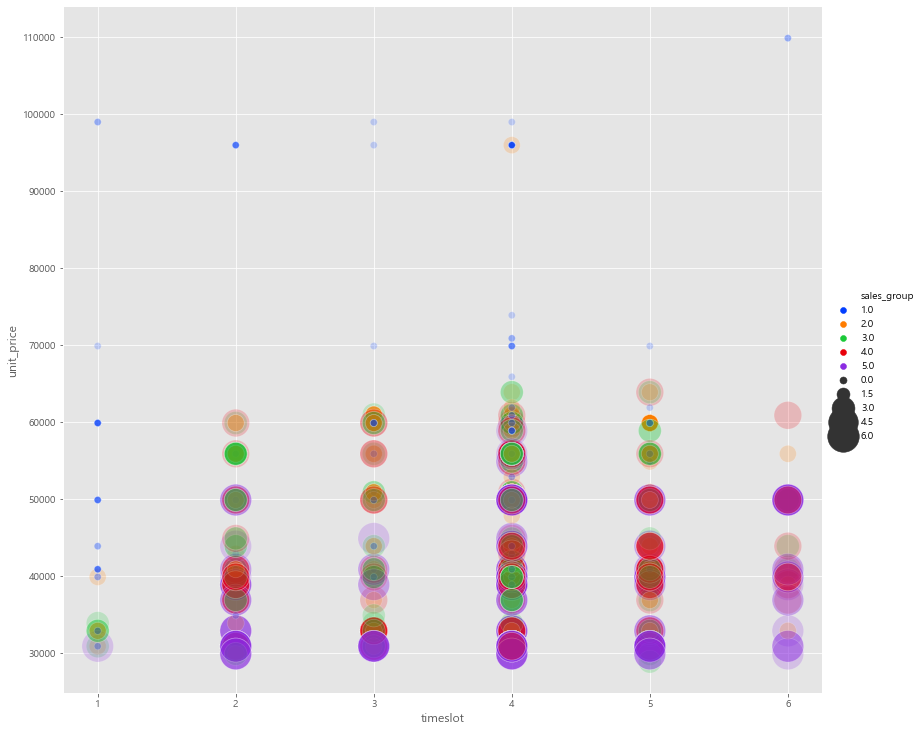

In [14]:
sns.relplot(x='timeslot',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='농수축'], alpha=0.2, height=10.27, aspect=11.7/10.27)

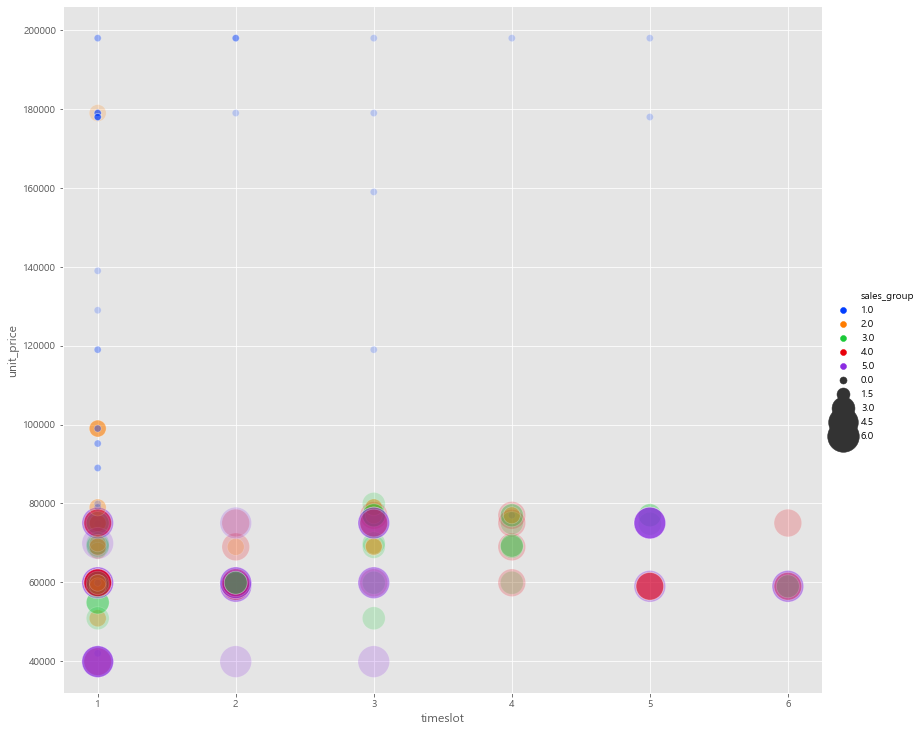

In [15]:
sns.relplot(x='timeslot',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='건강기능'], alpha=0.2, height=10.27, aspect=11.7/10.27)

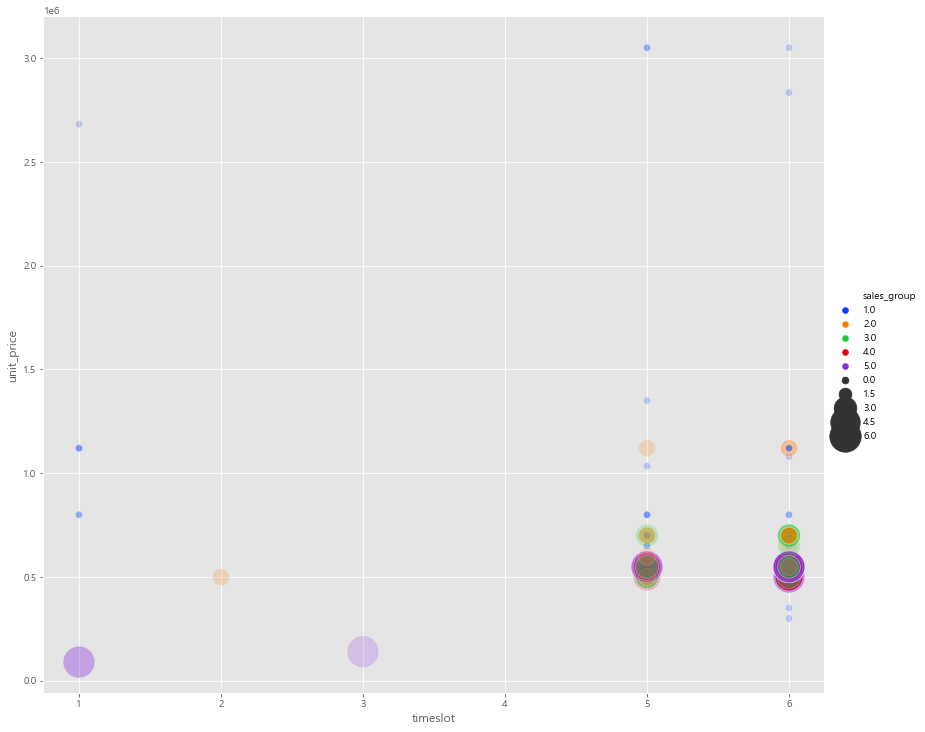

In [16]:
sns.relplot(x='timeslot',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='가구'], alpha=0.2, height=10.27, aspect=11.7/10.27)

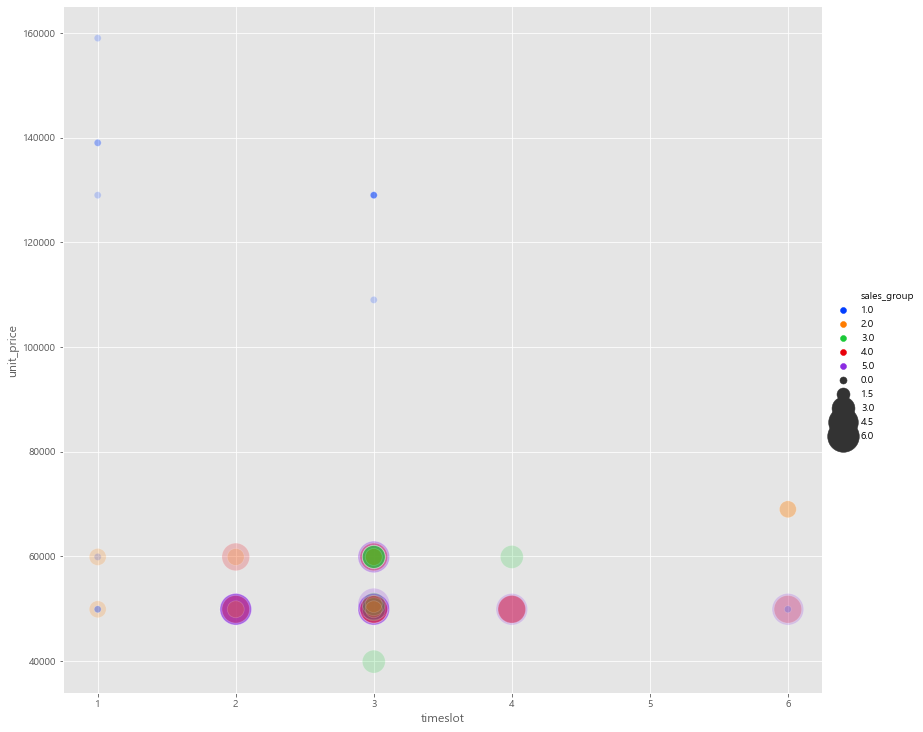

In [17]:
sns.relplot(x='timeslot',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='침구'], alpha=0.2, height=10.27, aspect=11.7/10.27)

# 요일별

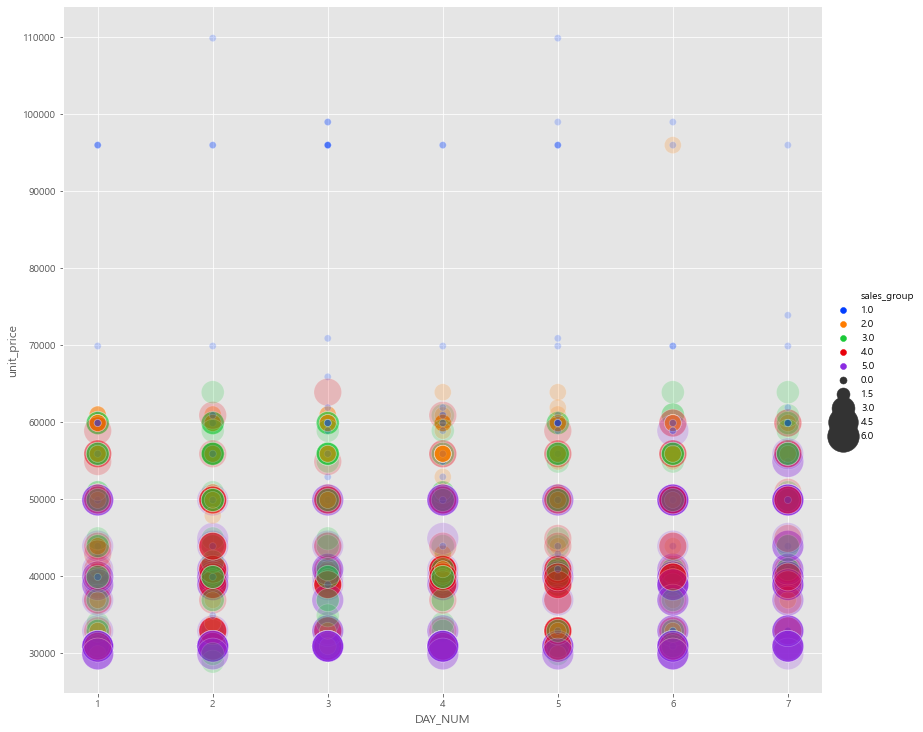

In [18]:
sns.relplot(x='DAY_NUM',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='농수축'], alpha=0.2, height=10.27, aspect=11.7/10.27)

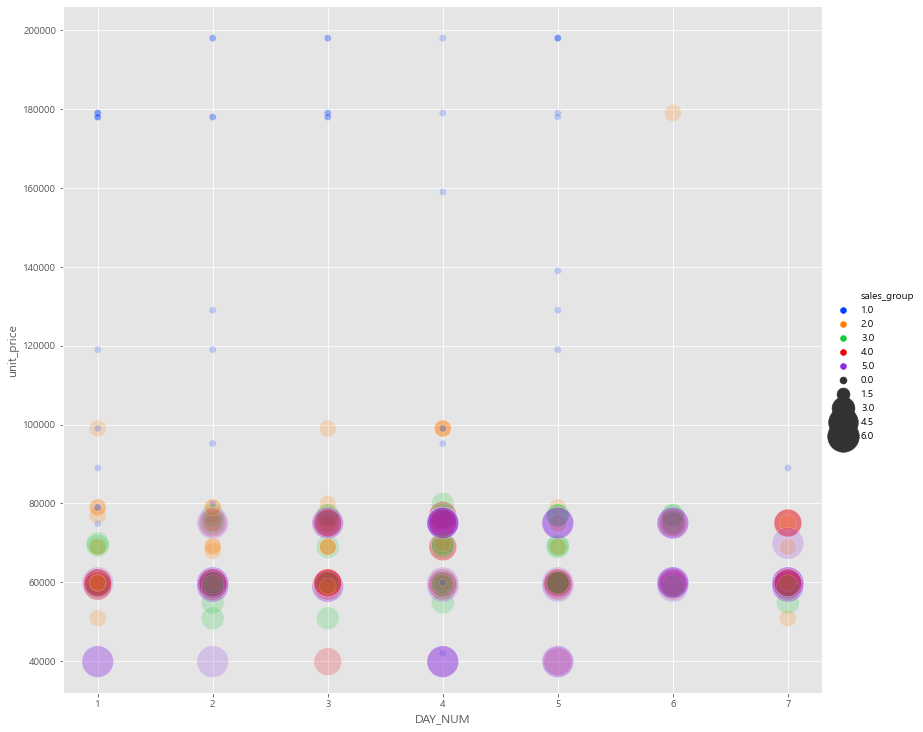

In [19]:
sns.relplot(x='DAY_NUM',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='건강기능'], alpha=0.2, height=10.27, aspect=11.7/10.27)

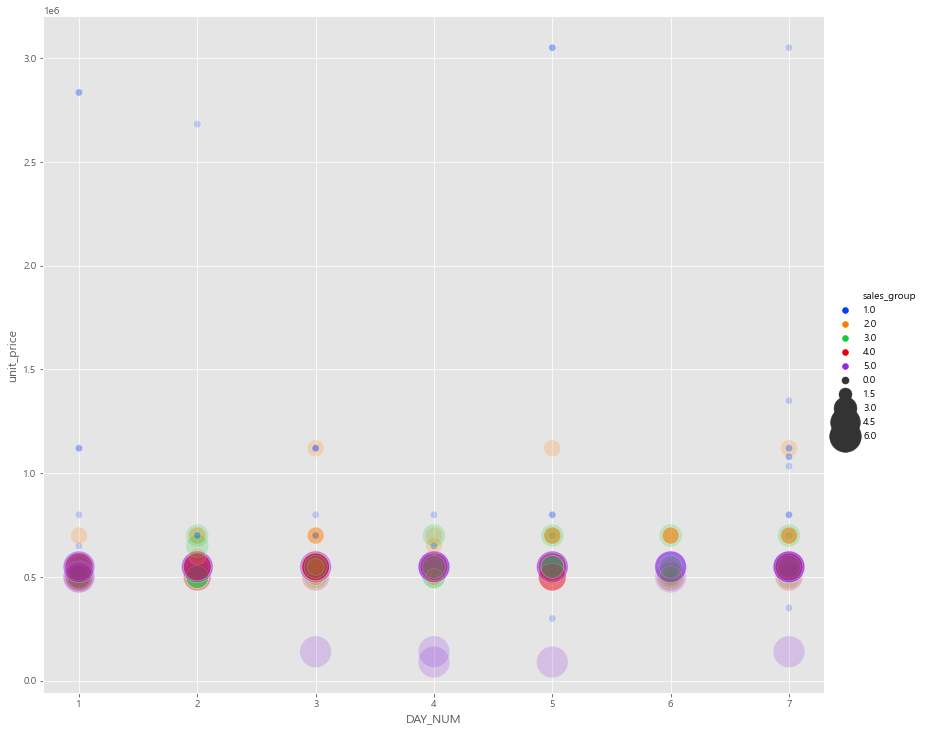

In [20]:
sns.relplot(x='DAY_NUM',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='가구'], alpha=0.2, height=10.27, aspect=11.7/10.27)

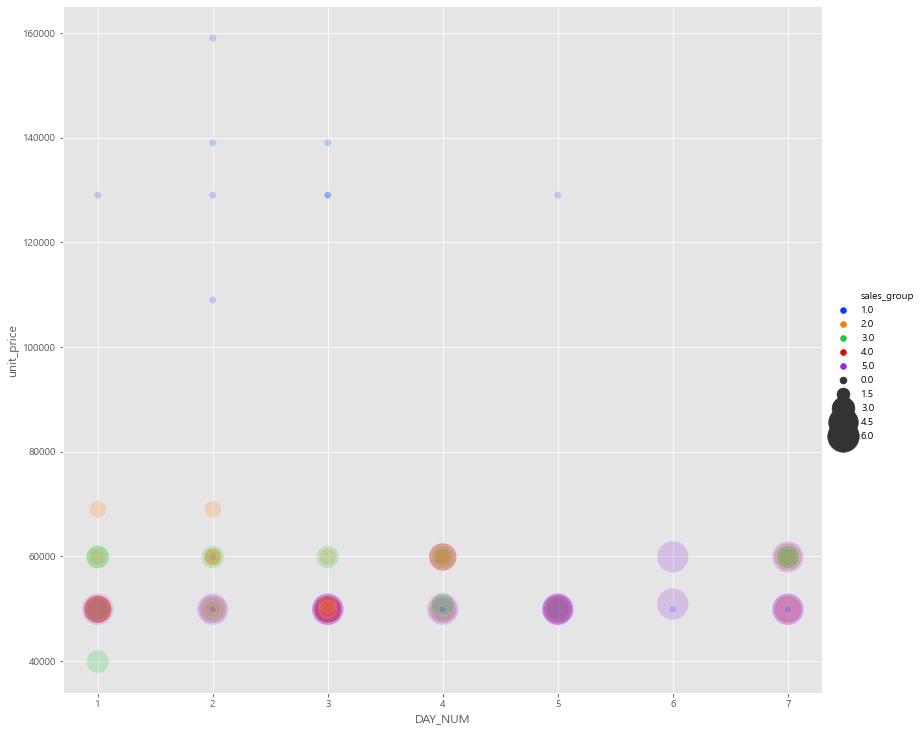

In [21]:
sns.relplot(x='DAY_NUM',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='침구'], alpha=0.2, height=10.27, aspect=11.7/10.27)

# 시즌별

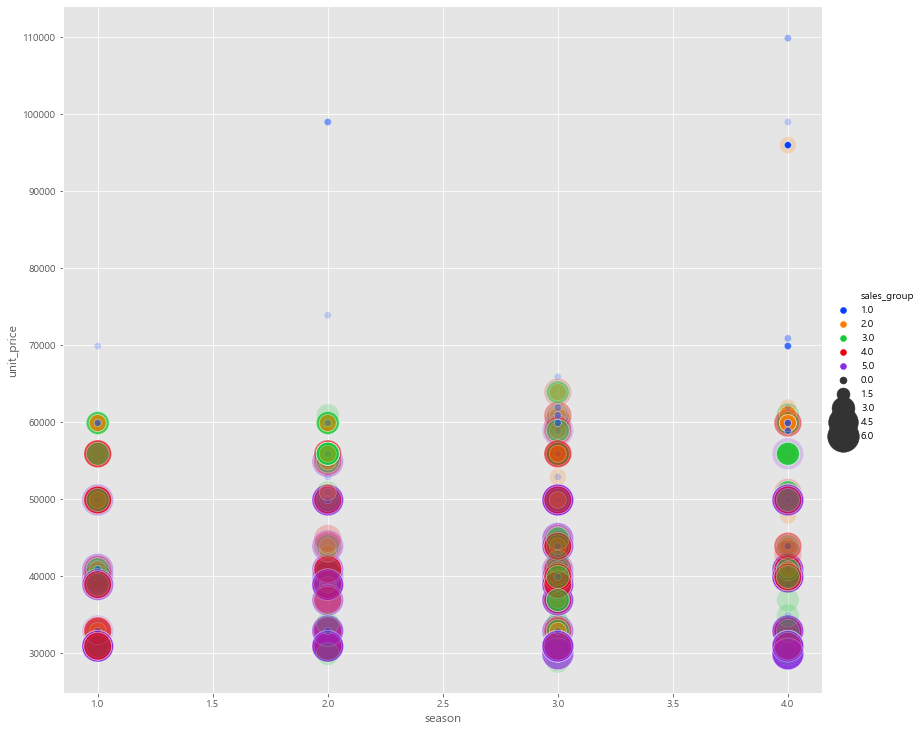

In [22]:
sns.relplot(x='season',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='농수축'], alpha=0.2, height=10.27, aspect=11.7/10.27)

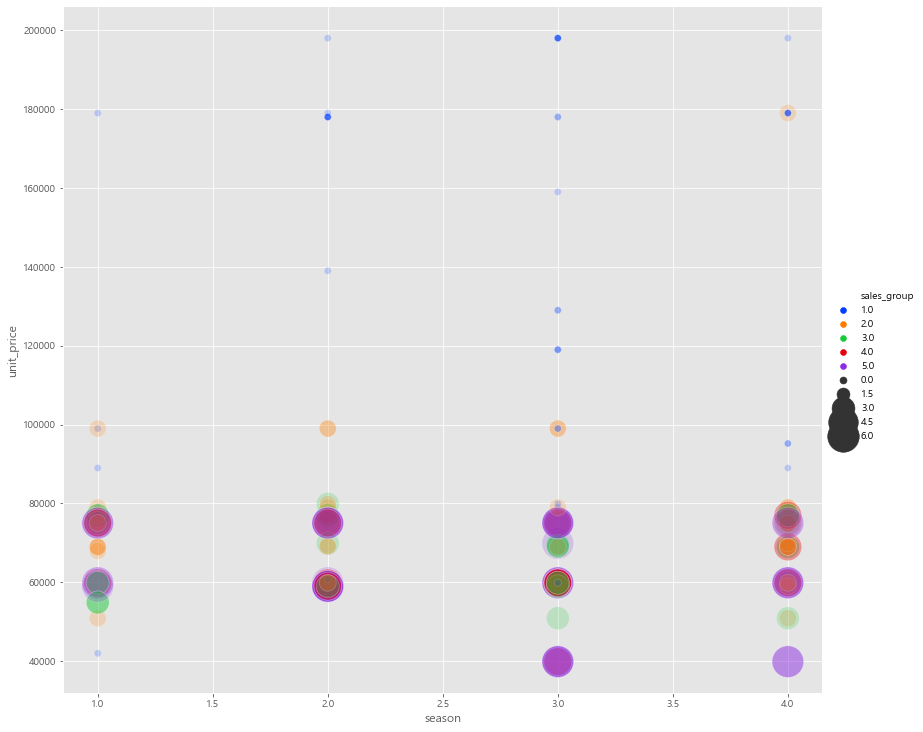

In [23]:
sns.relplot(x='season',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='건강기능'], alpha=0.2, height=10.27, aspect=11.7/10.27)

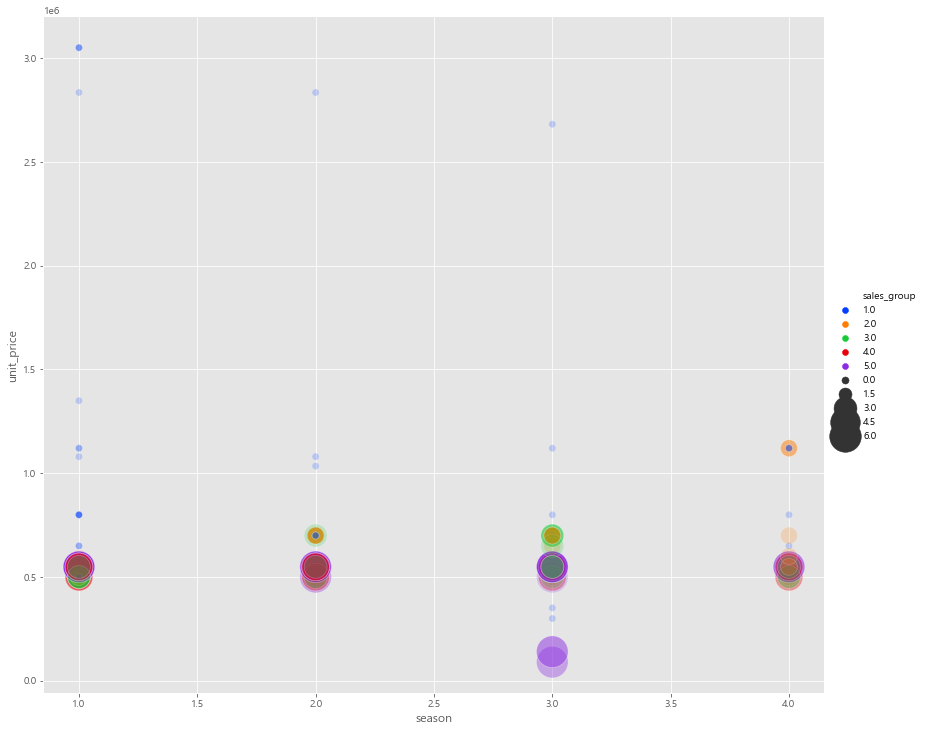

In [24]:
sns.relplot(x='season',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='가구'], alpha=0.2, height=10.27, aspect=11.7/10.27)

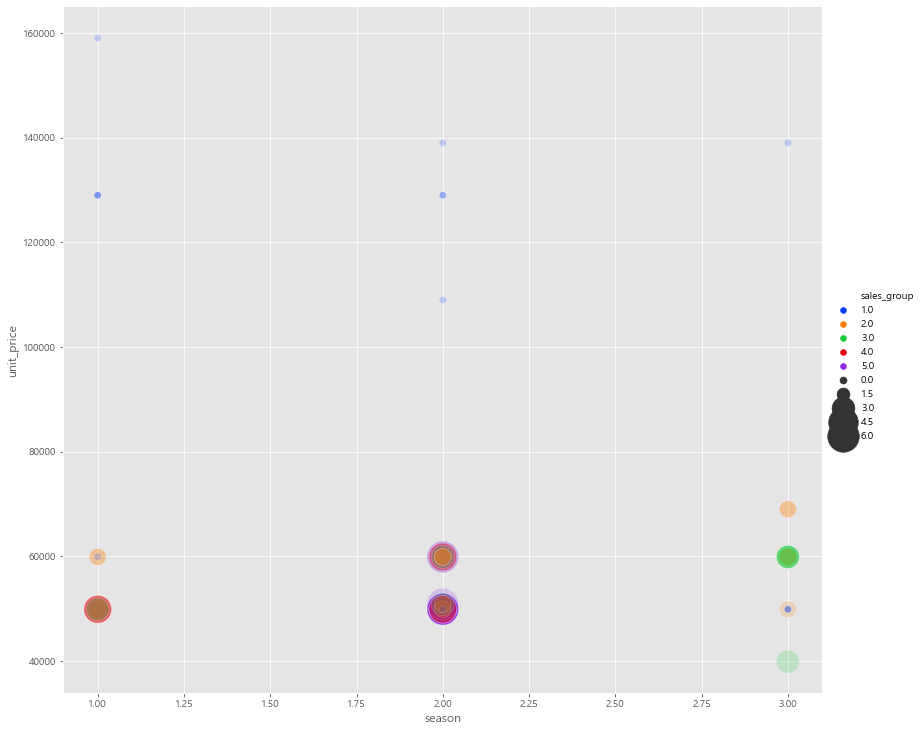

In [25]:
sns.relplot(x='season',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='침구'], alpha=0.2, height=10.27, aspect=11.7/10.27)

# 휴일 or 공휴일 ... 구분의 의미가 없어보인다. 통계적 검정 추가해보기?!

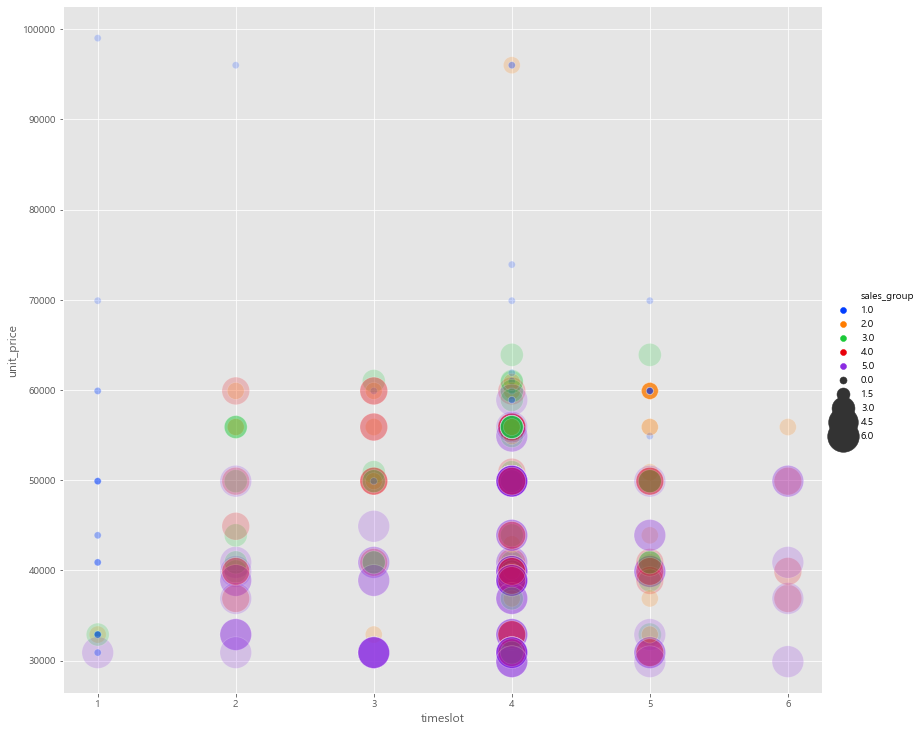

In [26]:
sns.relplot(x='timeslot',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[(sum_df['p_group']=='농수축')&(sum_df['holiday']==1)], alpha=0.2, height=10.27, aspect=11.7/10.27)

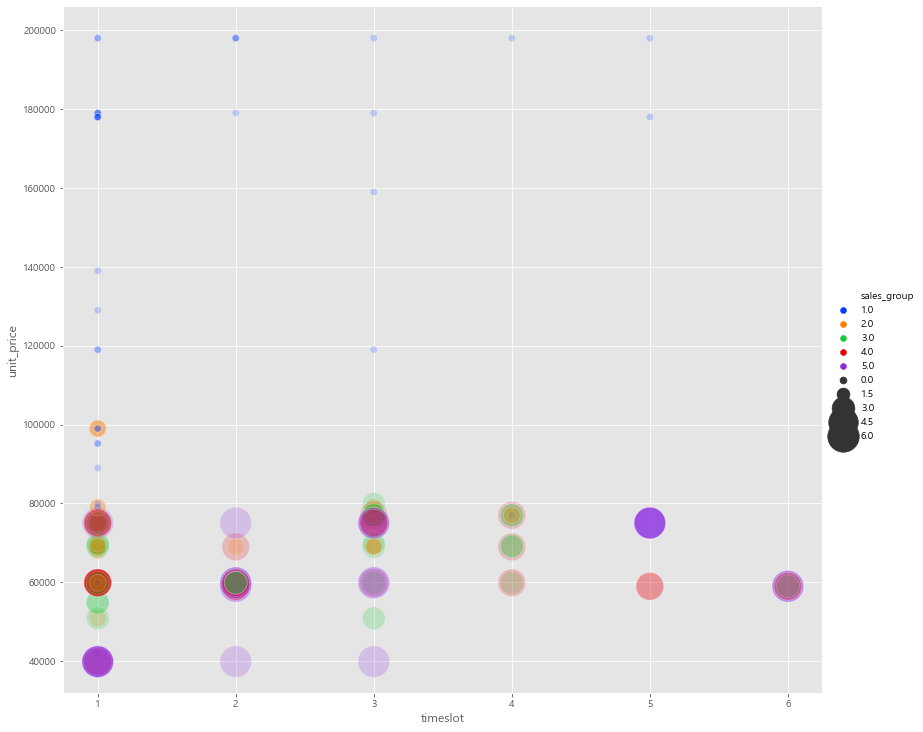

In [49]:
sns.relplot(x='timeslot',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[(sum_df['p_group']=='건강기능')&(sum_df['holiday']==0)], alpha=0.2, height=10.27, aspect=11.7/10.27)

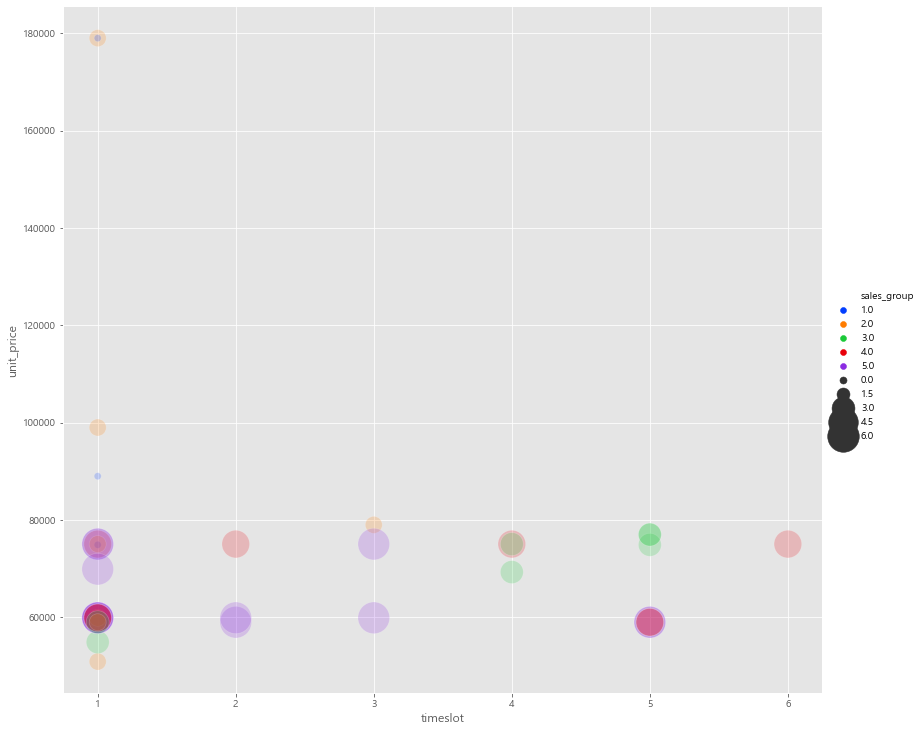

In [51]:
sns.relplot(x='timeslot',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[(sum_df['p_group']=='건강기능')&(sum_df['holiday']==1)], alpha=0.2, height=10.27, aspect=11.7/10.27)

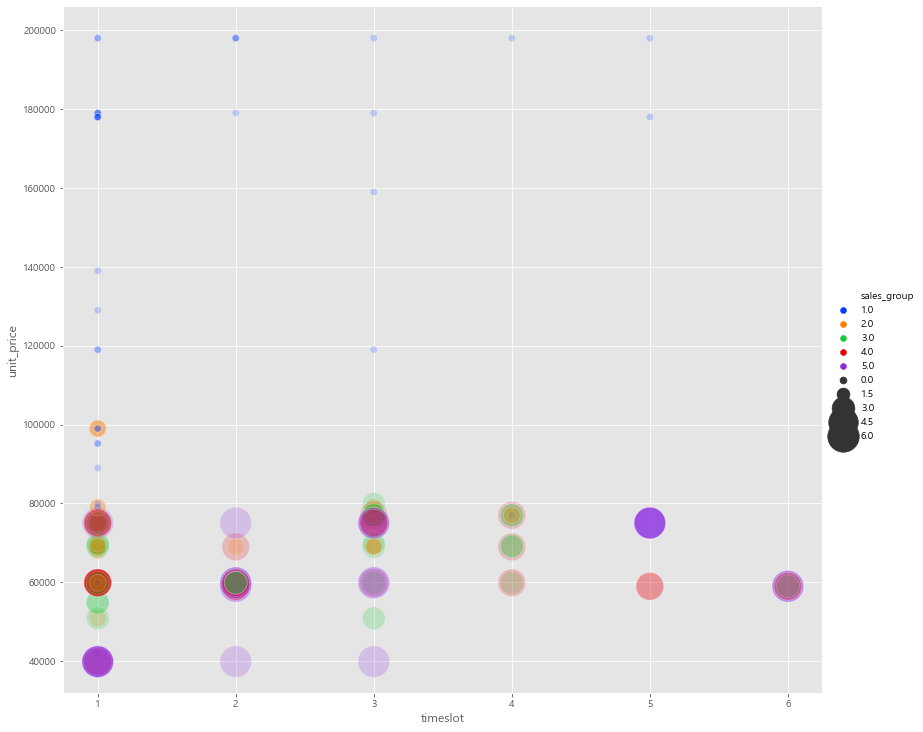

In [50]:
sns.relplot(x='timeslot',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[(sum_df['p_group']=='건강기능')&(sum_df['holiday']==0)], alpha=0.2, height=10.27, aspect=11.7/10.27)

어떤 구간의 판매량 / 전체 판매량 > 0.5인 어떤 구간을 찾아서 그 구간 안의 sales_group이 1(최하)인 상품들을 추려낸다.

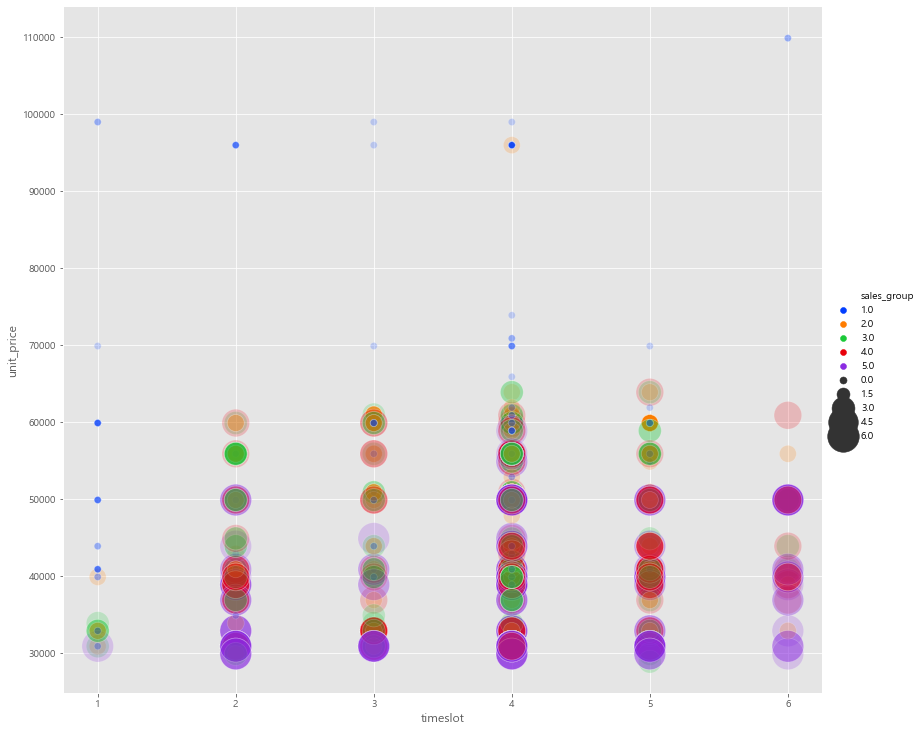

In [30]:
sns.relplot(x='timeslot',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='농수축'], alpha=0.2, height=10.27, aspect=11.7/10.27)

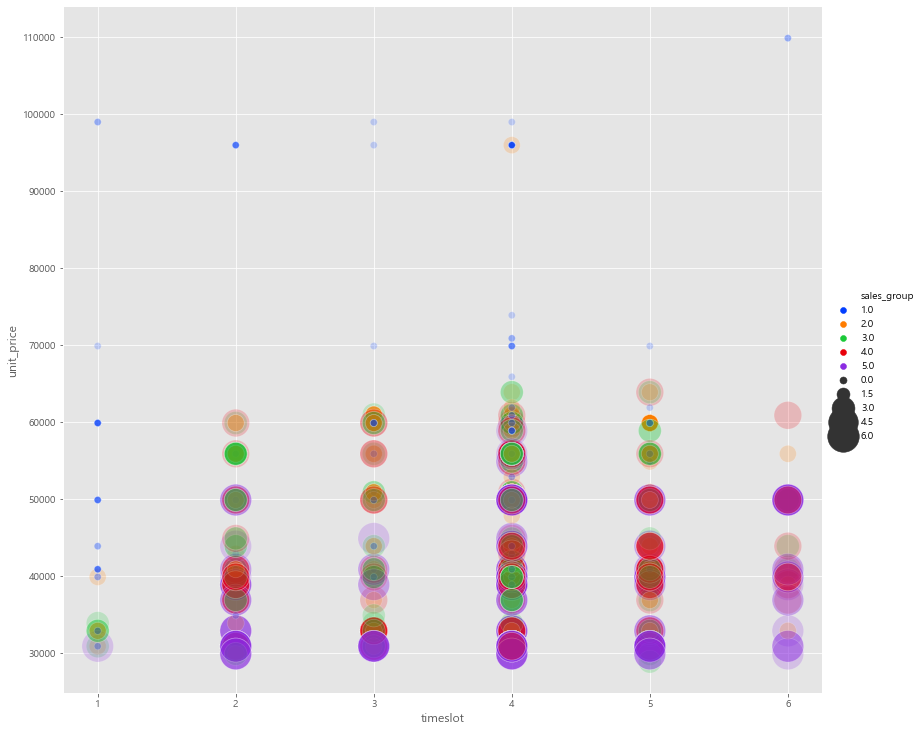

In [36]:
sns.relplot(x='timeslot',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='농수축'], alpha=0.2, height=10.27, aspect=11.7/10.27)

In [303]:
list(sum_df.p_group.unique())

['의류', '속옷', '주방', '농수축', '이미용', '가전', '생활용품', '건강기능', '잡화', '가구', '침구']

In [225]:
interested_group = list(sum_df.p_group.unique())

group_solution_dict = {}

for group in interested_group:
    df = sum_df[sum_df['p_group']==group]
    solution_list = []
    df_total_sales = df.sales.sum()
    print(group,'의 unit_price 개수:',len(df.unit_price.unique()))
    for idx, x in enumerate(sorted(df.unit_price.unique())):
        if idx % 10 == 0:
            print(idx, x)
        for y in sorted(df.unit_price.unique()):
            if x >= y:
                continue
            elif ((df[(df['unit_price'] >= x) & (df['unit_price'] <= y)].sales.sum() / df_total_sales) >= 0.495) &\
            ((df[(df['unit_price'] >= x) & (df['unit_price'] <= y)].sales.sum() / df_total_sales) <= 0.505):
                solution_list.append((x,y))
    group_solution_dict[group]=solution_list
group_solution_dict

의류 의 unit_price 개수: 48
0 29000
10 44900
20 66000
30 129000
40 399000
속옷 의 unit_price 개수: 26
0 29900
10 63200
20 109000
주방 의 unit_price 개수: 75
0 24900
10 50900
20 64800
30 79800
40 93000
50 123000
60 179000
70 254000
농수축 의 unit_price 개수: 34
0 28900
10 41900
20 55900
30 73900
이미용 의 unit_price 개수: 14
0 39800
10 69800
가전 의 unit_price 개수: 33
0 164000
10 829000
20 1330000
30 1959000
생활용품 의 unit_price 개수: 61
0 12800
10 39900
20 52900
30 89000
40 129000
50 219000
60 1880000
건강기능 의 unit_price 개수: 26
0 39900
10 69900
20 129000
잡화 의 unit_price 개수: 50
0 29000
10 49800
20 79800
30 169000
40 380000
가구 의 unit_price 개수: 18
0 89000
10 799000
침구 의 unit_price 개수: 9
0 39900


{'의류': [(29000, 49800),
  (34000, 59000),
  (40800, 79000),
  (44000, 79000),
  (49800, 299000),
  (49800, 399000),
  (49800, 499000),
  (49800, 690000),
  (49900, 399000),
  (49900, 499000),
  (49900, 690000),
  (49900, 699000),
  (49900, 1490000),
  (49900, 1590000),
  (49900, 1690000),
  (49900, 2490000)],
 '속옷': [(59900, 109000)],
 '주방': [(24900, 89000),
  (29800, 89000),
  (39900, 89800),
  (39900, 90000),
  (39900, 90800),
  (39900, 93000),
  (41900, 99000),
  (41900, 104000),
  (49000, 99000),
  (49000, 104000),
  (49800, 104000),
  (61800, 154000),
  (79800, 198000),
  (79900, 198000),
  (79900, 199000),
  (80000, 198000),
  (80000, 199000),
  (80000, 208000),
  (84000, 198000),
  (84000, 199000),
  (84000, 208000),
  (84800, 208000),
  (88800, 209000),
  (88800, 219000),
  (88800, 228000),
  (88800, 229000),
  (89000, 209000),
  (89000, 219000),
  (89000, 228000),
  (89000, 229000),
  (89000, 238000),
  (89000, 239000),
  (89000, 254000),
  (89000, 259000),
  (89000, 309000),


In [270]:
picked_solutions = {}

for group in interested_group:
    if len(group_solution_dict[group]) == 0:
        continue
    elif len(group_solution_dict[group]) == 1:
        picked_solutions[group] = group_solution_dict[group][0]
        continue
    else:
        min_range = abs(group_solution_dict[group][0][0]-group_solution_dict[group][0][1])
        chosen_values = (group_solution_dict[group][0][0], group_solution_dict[group][0][1])
        for x, y in group_solution_dict[group][1:]:
            if min_range > abs(x-y):
                min_range = abs(x-y)
                chosen_values = (x,y)
    picked_solutions[group] = chosen_values

In [273]:
picked_solutions

{'의류': (29000, 49800),
 '속옷': (59900, 109000),
 '주방': (39900, 89800),
 '농수축': (40900, 60900),
 '생활용품': (29800, 59800),
 '건강기능': (59000, 69300),
 '잡화': (29800, 48900)}

In [252]:
for key, value in picked_solutions.items():
    x, y = value
    
    df_split('농수축')[(df_split('농수축').unit_price >= 40900) & (df_split('농수축').unit_price <= 60900)&(df_split('농수축').sales_group==1)]

In [285]:
low_perform_dict = {}
for key, value in list(picked_solutions.items()):
    x, y = value
    df = df_split(key)[(df_split(key).unit_price >= x) & (df_split(key).unit_price <= y)&(df_split(key).sales_group==1)]
    low_perform_dict[key] = df

In [286]:
high_perform_dict = {}
for key, value in list(picked_solutions.items()):
    x, y = value
    df = df_split(key)[(df_split(key).unit_price >= x) & (df_split(key).unit_price <= y)&(df_split(key).sales_group==5)]
    high_perform_dict[key] = df

In [313]:
low_perform_dict.keys()

dict_keys(['의류', '속옷', '주방', '농수축', '생활용품', '건강기능', '잡화'])

In [323]:
import pickle

with open('c:/bc/low_perform_dict.pickle', 'wb') as f:
    pickle.dump(low_perform_dict, f)

In [324]:
with open('c:/bc/high_perform_dict.pickle', 'wb') as f:
    pickle.dump(high_perform_dict, f)

unit_price_range 못구한 것들(['이미용','가전','침구','가구']) 범위 조정하기

In [302]:
rest_group = ['이미용','가전','침구','가구']
rest_group_solution_dict = {}

for group in rest_group:
    df = sum_df[sum_df['p_group']==group]
    solution_list = []
    df_total_sales = df.sales.sum()
    print(group,'의 unit_price 개수:',len(df.unit_price.unique()))
    for idx, x in enumerate(sorted(df.unit_price.unique())):
        for y in sorted(df.unit_price.unique()):
            if x >= y:
                continue
            elif ((df[(df['unit_price'] >= x) & (df['unit_price'] <= y)].sales.sum() / df_total_sales) >= 0.41) &\
            ((df[(df['unit_price'] >= x) & (df['unit_price'] <= y)].sales.sum() / df_total_sales) <= 0.59):
                solution_list.append((x,y))
    rest_group_solution_dict[group]=solution_list
rest_group_solution_dict

이미용 의 unit_price 개수: 14
가전 의 unit_price 개수: 33
침구 의 unit_price 개수: 9
가구 의 unit_price 개수: 18


{'이미용': [(39900, 69900), (39900, 79000), (39900, 79900)],
 '가전': [(164000, 489000),
  (164000, 509000),
  (164000, 779000),
  (164000, 809000),
  (164000, 829000),
  (164000, 899000),
  (309000, 489000),
  (309000, 509000),
  (309000, 779000),
  (309000, 809000),
  (309000, 829000),
  (309000, 899000),
  (329000, 489000),
  (329000, 509000),
  (329000, 779000),
  (329000, 809000),
  (329000, 829000),
  (329000, 899000),
  (434000, 489000),
  (434000, 509000),
  (434000, 779000),
  (434000, 809000),
  (434000, 829000),
  (434000, 899000),
  (439000, 509000),
  (439000, 779000),
  (439000, 809000),
  (439000, 829000),
  (439000, 899000),
  (439000, 999000),
  (459000, 1300000),
  (459000, 1319000),
  (459000, 1330000),
  (459000, 1359000),
  (459000, 1385000),
  (489000, 1300000),
  (489000, 1319000),
  (489000, 1330000),
  (489000, 1359000),
  (489000, 1385000),
  (509000, 1359000),
  (509000, 1385000),
  (509000, 1409000),
  (509000, 1419000),
  (509000, 1469000),
  (509000, 1519000),


In [ ]:
0.495 ~ 0.505

이미용 0.45 ~ 0.55-> 0.54
가전 0.49 ~ 0.51-> 0.5
침구 0.41 ~ 0.59-> 0.43
가구 0.43 ~0.57-> 0.47

In [308]:
temp=pd.read_csv('c:/bc/nsc.csv')
temp[:20]

,broadcast,exp_min,m_code,p_code,p_name,p_group,unit_price,total_price,sales,YEAR,...,DAY_NUM,p_group_code,new_code,no,sales_level,grade,season,timeslot,holiday,sales_group
0,2019-01-01 15:00:00,60.000000,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,농수축,60900,86177000.0,1415.0,2019,...,2,3,3.0,29,c,3,4,4,1,1.0
1,2019-01-03 17:00:00,60.000000,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,농수축,60900,76649000.0,1258.0,2019,...,4,3,43.0,215,c,3,4,4,0,1.0
2,2019-01-05 18:20:00,40.000000,100801,202365,바다먹자 국내산 손질꽃게 7팩,농수축,59900,76992000.0,1286.0,2019,...,6,3,86.0,391,c,3,4,5,1,1.0
3,2019-01-05 01:00:00,57.100000,100430,201343,(a4)팽현숙의 순대 곱창 전골&볶음,농수축,43900,55476000.0,1264.0,2019,...,6,3,84.0,444,c,4,4,1,1,1.0
4,2019-01-08 17:00:00,60.000000,100801,202365,바다먹자 국내산 손질꽃게 7팩,농수축,59900,113015000.0,1886.0,2019,...,2,3,145.0,662,d,3,4,4,0,1.0
5,2019-01-09 13:00:00,60.000000,100740,202171,농협안심벌꿀 4병,농수축,59900,91804000.0,1532.0,2019,...,3,3,166.0,760,c,3,4,3,0,1.0
6,2019-01-10 15:00:00,60.000000,100198,200669,소들녘 더 맛있는 NEW 돼지왕구이 12팩,농수축,51900,64374000.0,1241.0,2019,...,4,3,184.0,839,c,4,4,4,0,1.0
7,2019-01-10 18:00:00,60.000000,100801,202365,바다먹자 국내산 손질꽃게 7팩,농수축,59900,106158000.0,1772.0,2019,...,4,3,189.0,848,d,3,4,5,0,1.0
8,2019-01-11 12:00:00,60.000000,100832,202444,청정수산 완도활전복 35미,농수축,59900,110642000.0,1847.0,2019,...,5,3,206.0,927,d,3,4,3,0,1.0
9,2019-01-11 17:00:00,60.000000,100801,202365,바다먹자 국내산 손질꽃게 7팩,농수축,59900,89775000.0,1499.0,2019,...,5,3,205.0,942,c,3,4,4,0,1.0
